In [37]:
import pandas as pd
import numpy as np
import math
from IPython.display import Markdown, display
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt    
from dataHack import removeColl 
%matplotlib inline
import warnings
import scipy
warnings.filterwarnings('ignore')
import networkx as nx
%load_ext autotime
def printmd(string):
    display(Markdown(string))
import plotly.offline as py1
py1.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import plotly
import plotly.plotly as py
from plotly.tools import FigureFactory as ff
plotly.tools.set_credentials_file(username='sushant.bharti', api_key='WptZURbEo6AnBZpSHNgO')
plt.style.use('seaborn-bright')
pal = sns.color_palette()

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


time: 1.2 s


In [38]:
df_train = pd.read_csv('../quora pairs/train.csv')
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


time: 1.91 s


Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780
()


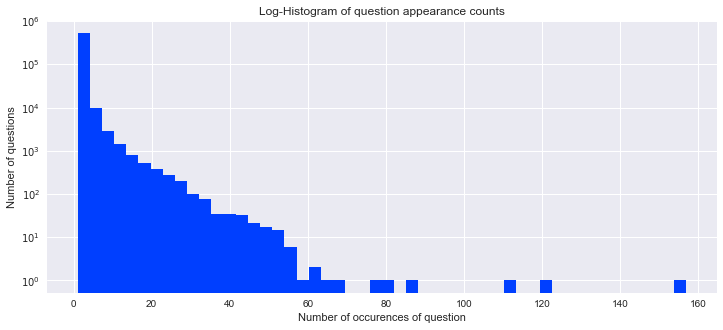

time: 2.03 s


In [39]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

In [40]:
from sklearn.metrics import log_loss

p = df_train['is_duplicate'].mean() # Our predicted probability
printmd('### Predicted score:'+ str( log_loss(df_train['is_duplicate'], np.zeros_like(df_train['is_duplicate']) + p)))

df_test = pd.read_csv('test.csv')
sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})


### Predicted score:0.658527383984

time: 12.8 s


In [41]:
printmd('#### LB score 0.55 ')

#### LB score 0.55 

Error in callback <bound method LineWatcher.stop of <autotime.LineWatcher object at 0x000000000B5CB470>> (for post_run_cell):


AssertionError: 

In [42]:
print('Total number of question pairs for testing: {}'.format(len(df_test)))

Total number of question pairs for testing: 2345796
time: 474 ms


# Characters per question

mean-train 59.86 std-train 31.99 mean-test 60.11 std-test 31.66 max-train 1169.00 max-test 1176.00


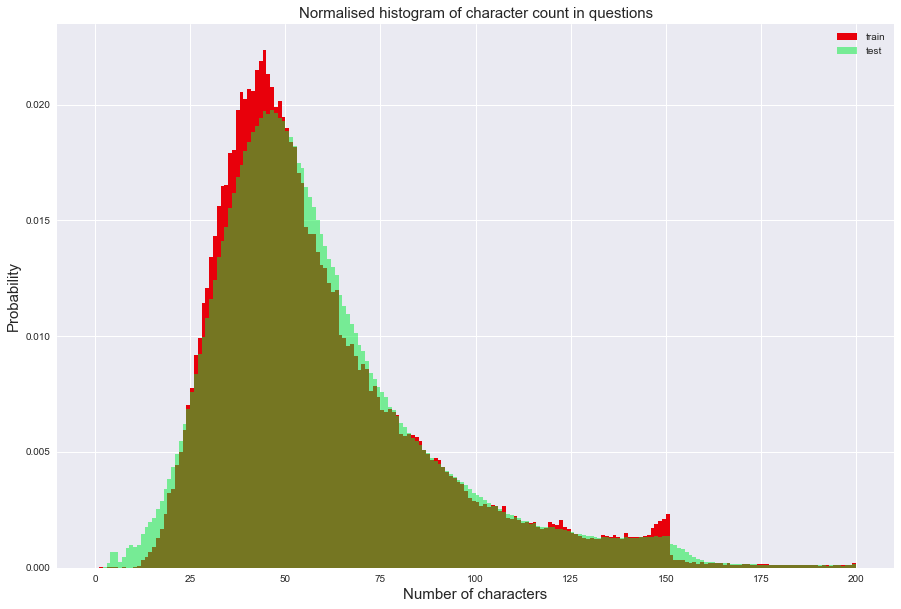

time: 13.4 s


In [43]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)
printmd('# Characters per question')
print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

# Words per Question

mean-train 11.06 std-train 5.89 mean-test 11.02 std-test 5.84 max-train 237.00 max-test 238.00


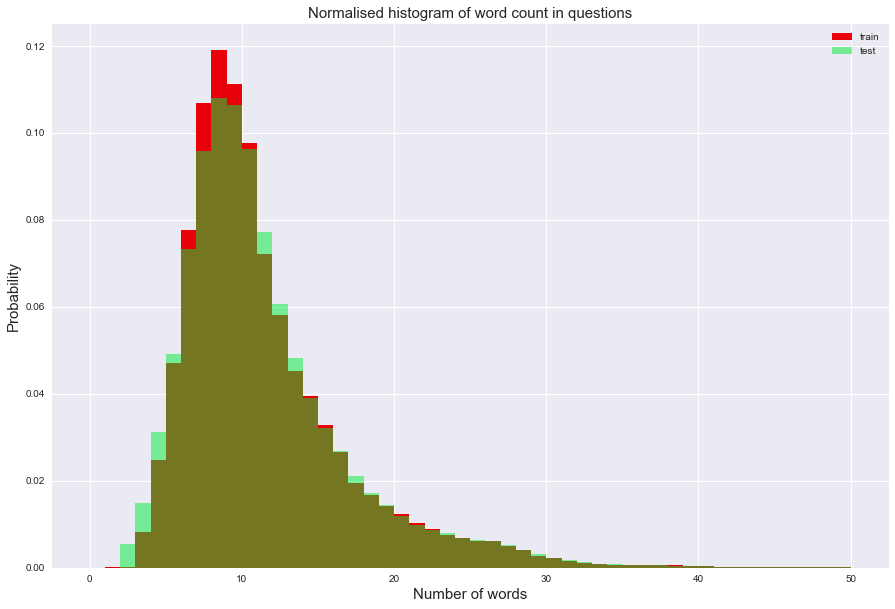

time: 9.77 s


In [44]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)
printmd('# Words per Question')
print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

(-0.5, 1439.5, 1079.5, -0.5)

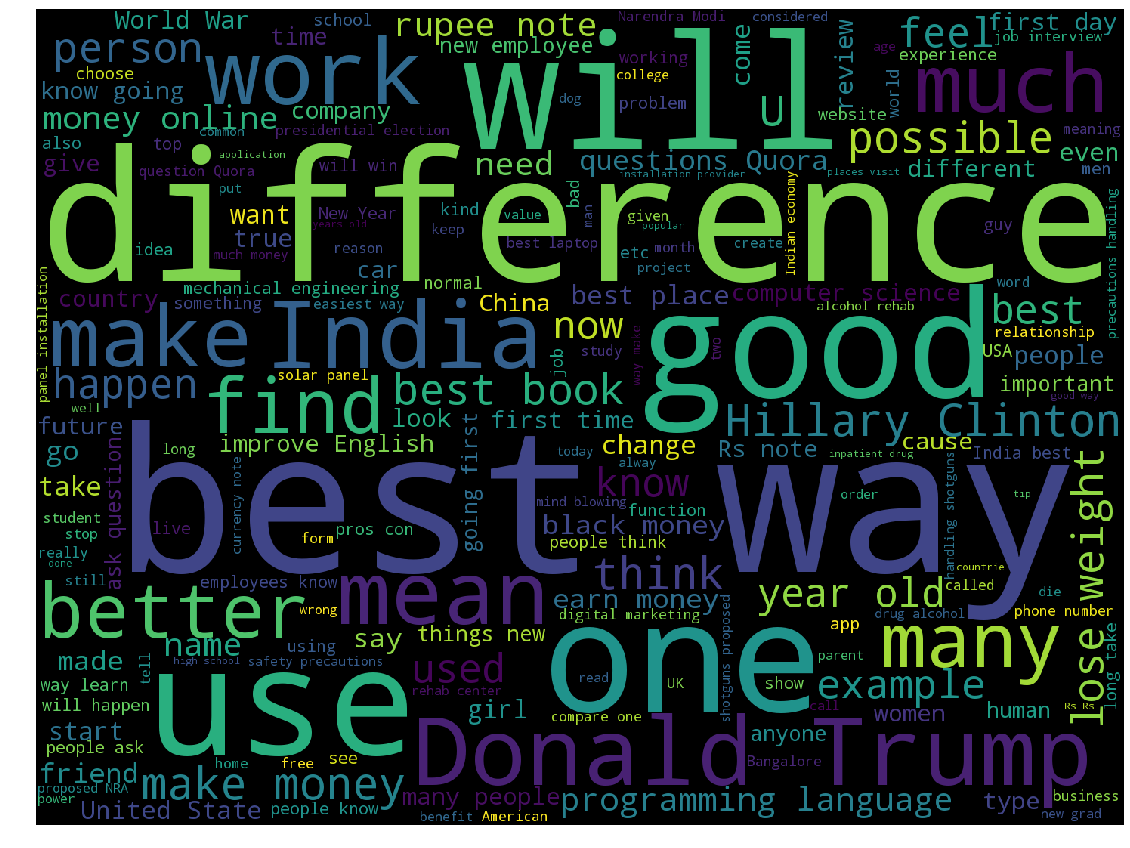

time: 1min 13s


In [45]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

# Semantic Analysis

In [46]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 99.87%
Questions with [math] tags: 0.12%
Questions with full stops: 6.31%
Questions with capitalised first letters: 99.81%
Questions with capital letters: 99.95%
Questions with numbers: 11.83%
time: 20.8 s


## Word share

In [47]:
def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split()))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split()))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

df_train.fillna('',inplace=True)
df_train['word_share']=df_train.apply(normalized_word_share, axis=1)


time: 22.3 s


In [48]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.100000


time: 184 ms


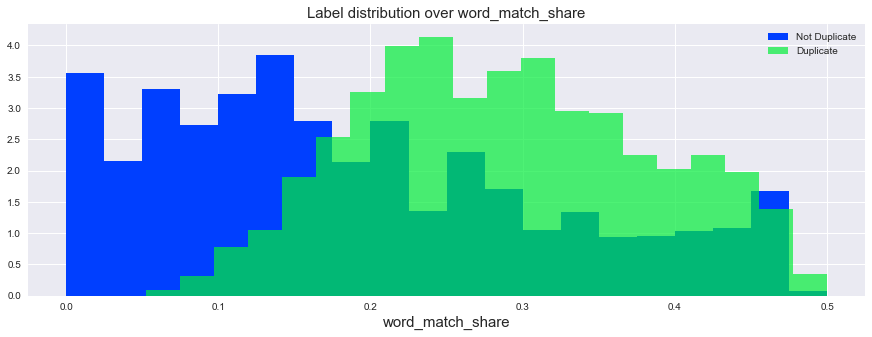

time: 982 ms


In [49]:
plt.figure(figsize=(15,5))
plt.hist(df_train['word_share'][df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(df_train['word_share'][df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)


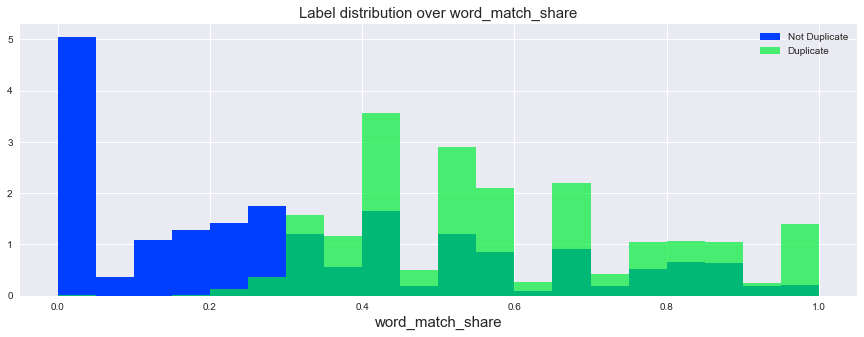

time: 20.4 s


In [50]:
from nltk.corpus import stopwords
df_train.fillna('',inplace=True)
stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = float(len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1 ,raw=True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [51]:
#len(obj.idf_),len(train_qs),len(obj.get_feature_names()),len(set(words))

Error in callback <bound method LineWatcher.stop of <autotime.LineWatcher object at 0x000000000B5CB470>> (for post_run_cell):


AssertionError: 

In [59]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / float(count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

time: 5.83 s


In [60]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 2.5891040146646852e-06), ('what', 3.115623919267953e-06), ('is', 3.5861702928825277e-06), ('how', 4.366449945201053e-06), ('i', 4.4805878531263305e-06), ('a', 4.540645588989843e-06), ('to', 4.671434644293609e-06), ('in', 4.884625153865692e-06), ('of', 5.920242493132519e-06), ('do', 6.070908207867897e-06)]

Least common words and weights: 


[('kernel:', 9.998000399920016e-05),
 ('chameleons', 9.998000399920016e-05),
 ('275', 9.998000399920016e-05),
 ('276', 9.998000399920016e-05),
 ('kid:', 9.998000399920016e-05),
 ('usenet', 9.998000399920016e-05),
 ('(football', 9.998000399920016e-05),
 ('sneha', 9.998000399920016e-05),
 ('population)', 9.998000399920016e-05),
 (',delhi', 9.998000399920016e-05)]

time: 1.42 s


In [61]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

time: 16 ms


In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
obj = TfidfVectorizer()
corpus = train_qs
#X = obj.fit_transform(corpus)



time: 2.98 s


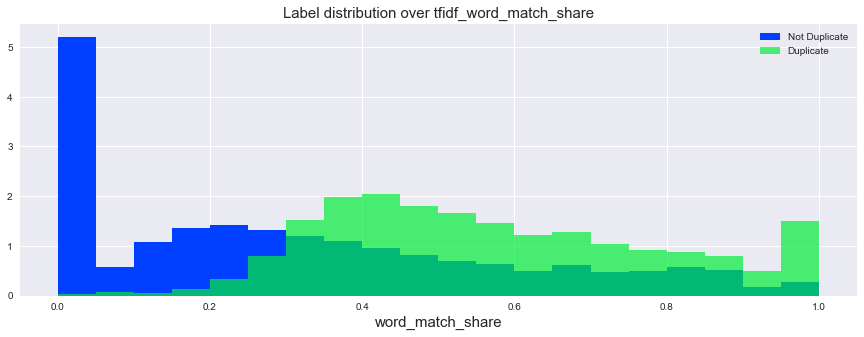

time: 32.6 s


In [62]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1)
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [67]:
# First we create our training and testing data
x_train = pd.DataFrame()
x_test = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_test['word_match'] = df_test.apply(word_match_share, axis=1, raw=True)
x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1, raw=True)

y_train = df_train['is_duplicate'].values

time: 5min


In [68]:
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((float((len(pos_train))) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(float(len(pos_train)) / (len(pos_train) + len(neg_train)))



0.191243661001
time: 69 ms


In [69]:
x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

time: 47 ms


In [70]:
# Finally, we split some of the data off for validation
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

time: 734 ms


In [71]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.683189	valid-logloss:0.683238
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.602041	valid-logloss:0.602515
[20]	train-logloss:0.544863	valid-logloss:0.545663
[30]	train-logloss:0.503151	valid-logloss:0.504194
[40]	train-logloss:0.471989	valid-logloss:0.473231
[50]	train-logloss:0.448341	valid-logloss:0.449746
[60]	train-logloss:0.430164	valid-logloss:0.431706
[70]	train-logloss:0.416072	valid-logloss:0.417726
[80]	train-logloss:0.405012	valid-logloss:0.406775
[90]	train-logloss:0.396327	valid-logloss:0.398177
[100]	train-logloss:0.389488	valid-logloss:0.391404
[110]	train-logloss:0.384071	valid-logloss:0.386038
[120]	train-logloss:0.379786	valid-logloss:0.381792
[130]	train-logloss:0.376375	valid-logloss:0.378414
[140]	train-logloss:0.373661	valid-logloss:0.375724
[150]	train-logloss:0.371482	valid-logloss:0.373567
[160]	train-logloss:0.369728

In [72]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('simple_xgb.csv', index=False)

time: 12.6 s
